# Склейка панорамы. Домашнее задание № 2

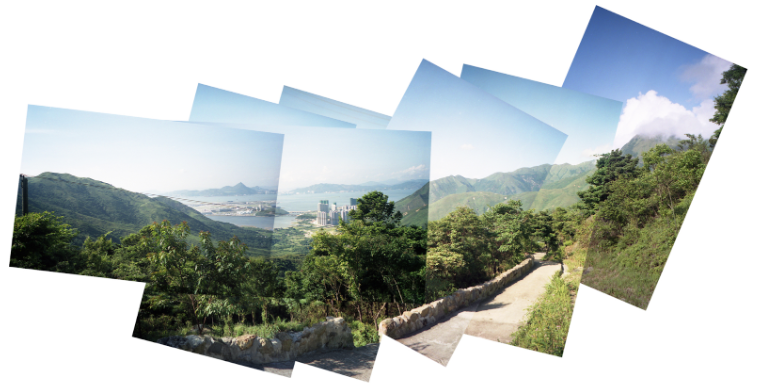

1. Нафотать какую-нибудь сцену с большим перекрытием между кадрами. (Только надо поворачивать, а не смещать камеру. Иначе эффект параллакса даст о себе знать)
2. Сматчить фото между собой. Визуализировать матчи на картинках и проверять фото на адекватность их матчей между собой. 
3. Затем нужно посчитать homography и склеить фото между собой.

```python
(matches, H, status) = M
		result = cv2.warpPerspective(imageA, H,
			(imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
		result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
```
Главная идея вот в этих строчках ниже. Посчитать homography между двумя картинками, а потом просто наложить их друг на друга. 

```python
(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
				reprojThresh)
```

4. * Задача со звёздочкой. Заменить SIFT-овые ключевые точки на [SuperPoint](https://github.com/rpautrat/SuperPoint) или [SiLK](https://github.com/facebookresearch/silk). Нужно поменять только код вычисления ключевых точек.


In [ ]:
# Зависимости
# ! pip install opencv-python
# ! pip install scikit-image
# ! pip install matplotlib
# ! pip install scipy

In [2]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import logging
import skimage.io as io

# Зависимости задачи со звёздочкой
# import torch
# from common import get_model, load_images, SILK_MATCHER
# from silk.backbones.silk.silk import from_feature_coords_to_image_coords
# from silk.cli.image_pair_visualization import create_img_pair_visual, save_image


### Чтение данных

In [3]:
images_paths = list(Path('./imgs').glob('./image_*'))
images_paths = sorted(images_paths)
image_list = []
for image_path in images_paths:
    image = cv2.imread(image_path.as_posix())
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_list.append(image)

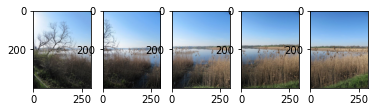

In [4]:
f, axarr = plt.subplots(1,5)
for i in range(len(image_list)) :
    axarr[i].imshow(image_list[i])
plt.show()

### Функции для :
1. evaluate_descriptor_for_image - извлечение ключевых точек и дескрипторов методом SIFT
2. match_keypoints - для сопоставления ключевых точек двух изображений, согласно ближайшим дескрипторам, используя метод k - ближайших соседей
3. draw_matches - для отрисовки сопоставленных ключевых точек в целях отладки

## Панорама с ключевыми точками из SIFT (40 балов)

In [5]:
def evaluate_descriptor_for_image(image : np.array, scale_factor: int = 1):
    SIFT = cv2.SIFT_create()
    orig_h, orig_w, _ = image.shape
    if scale_factor != 1 :
        image = cv2.resize(image, (orig_w // scale_factor, orig_h // scale_factor))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = SIFT.detectAndCompute(image, None)
    keypoints_orig = keypoints
    keypoints = np.asarray([[*kp.pt] for kp in keypoints], dtype=np.int32)
    keypoints[:, 0] = (keypoints[:, 0] / (orig_w // scale_factor)) * orig_w
    keypoints[:, 1] = (keypoints[:, 1] / (orig_h // scale_factor)) * orig_h
    return keypoints_orig, keypoints, descriptors
    
def match_keypoints(kpsA, kpsB, 
                    featuresA, featuresB, 
                    ratio=0.75, reprojThresh=4.0) :
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(featuresA, featuresB, k=2)
    good = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.7 * n.distance:
            good.append(m)


    matches = np.asarray(
       [[m.trainIdx, m.queryIdx] for m in good], dtype=np.int32)
    # computing a homography requires at least 4 matches
    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])
        # compute the homography between the two sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)
        #H = find_homography(ptsA, ptsB)
        # return the matches along with the homograpy matrix
        # and status of each matched point
        return (matches, H, status)
    # otherwise, no homograpy could be computed
    return None

def draw_matches(imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB
    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # only process the match if the keypoint was successfully
        # matched
        if s == 1:
            # draw the match
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
    # return the visualization
    return vis

### Опишем функции для устранения перекрытий и сглаживания границ

blending_mask - вычисляет маски для плавного перехода одного изображения в другое
panorama_blending - смешивает два изображения с заданными параметрами

*TODO: Реализовать в функции panorama_blending смешивание изображений с заданными масками*

In [9]:
def blending_mask(height, width, barrier, smoothing_window, left_biased=True):
    assert barrier < width
    mask = np.zeros((height, width))

    offset = int(smoothing_window / 2)
    try:
        if left_biased:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(1, 0, 2 * offset + 1).T, (height, 1)
            )
            mask[:, : barrier - offset] = 1
        else:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(0, 1, 2 * offset + 1).T, (height, 1)
            )
            mask[:, barrier + offset :] = 1
    except BaseException:
        if left_biased:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(1, 0, 2 * offset).T, (height, 1)
            )
            mask[:, : barrier - offset] = 1
        else:
            mask[:, barrier - offset : barrier + offset + 1] = np.tile(
                np.linspace(0, 1, 2 * offset).T, (height, 1)
            )
            mask[:, barrier + offset :] = 1

    return cv2.merge([mask, mask, mask])

def panorama_blending(dst_img_rz, src_img_warped, width_dst, side):
    h, w, _ = dst_img_rz.shape
    smoothing_window = int(width_dst / 8)
    barrier = width_dst - int(smoothing_window / 2)
    
    # Вычисление масок области перекрытия для изображений.
    mask1 = blending_mask(
        h, w, barrier, smoothing_window=smoothing_window, left_biased=True
    )
    mask2 = blending_mask(
        h, w, barrier, smoothing_window=smoothing_window, left_biased=False
    )

    if side == "left":
        dst_img_rz = cv2.flip(dst_img_rz, 1)
        src_img_warped = cv2.flip(src_img_warped, 1)
        
    # TODO: Используя mask1 и mask2 смешать изображения dst_img_rz и src_img_warped
    pano = ...

    if side == "left":
        pano = cv2.flip(pano, 1)

    return pano

### Опишем функции для нахождения и применения гомографии относительного правого изображения c учетом ключевых точек из метода SIFT

In [10]:
def crop(panorama, h_dst, conners):
    # find max min of x,y coordinate
    [xmin, ymin] = np.int32(conners.min(axis=0).ravel() - 0.5)
    t = [-xmin, -ymin]
    conners = conners.astype(int)

    # conners[0][0][0] is the X coordinate of top-left point of warped image
    # If it has value<0, warp image is merged to the left side of destination image
    # otherwise is merged to the right side of destination image
    if conners[0][0][0] < 0:
        n = abs(-conners[1][0][0] + conners[0][0][0])
        panorama = panorama[t[1] : h_dst + t[1], n:, :]
    else:
        if conners[2][0][0] < conners[3][0][0]:
            panorama = panorama[t[1] : h_dst + t[1], 0 : conners[2][0][0], :]
        else:
            panorama = panorama[t[1] : h_dst + t[1], 0 : conners[3][0][0], :]
    return panorama

def warp_two_images(src_img, dst_img):
    _, keypoints_src, descriptors_src = evaluate_descriptor_for_image(src_img)
    _, keypoints_dst, descriptors_dst = evaluate_descriptor_for_image(dst_img)
    print(keypoints_src.shape, descriptors_src.shape)
    
    # generate Homography matrix  and matche4s
    (matches, H, _) = match_keypoints(keypoints_src, keypoints_dst, 
                                      descriptors_src, descriptors_dst, True)

    # get height and width of two images
    height_src, width_src = src_img.shape[:2]
    height_dst, width_dst = dst_img.shape[:2]

    # TODO:
    # 1. Вычислить координаты углов изображений используя height_src, width_src и height_dst, width_dst
    # 2. Применить cv2.perspectiveTransform с матрицей гомографии H к координатам углов
    # 3. Используя координаты углов вычислить итоговый размер панорамы и какое из изображений находится левее
    # 4. Используя полученную информацию и функцию cv2.warpPerspective преобразовать одно из изображений
    

    # Смешиваем полученные изображения после трансформации
    # dst_img_rz - предварительно увеличенное до размеров понорамы изображение dst_img
    # src_img_warped - преобразованное для корректной конкатенации изображение src_img
    # side = "left" или "right" определить ранее в коде, какое изображение левее
    pano = panorama_blending(
        dst_img_rz, src_img_warped, width_dst, side
    )

    # Понадобится когда мы начнём склеивать больше 2 картинок. В целях отладки можно закомментировать и проверить без неё
    pano = crop(pano, height_dst, pts)

    return pano

### Отобразим ключевые точки метода SIFT

In [11]:
kp_orig_list = []
keypoints_list = []
descriptors_list = []
for image in image_list :
    kp_orig, keypoints, descriptors = evaluate_descriptor_for_image(image)
    kp_orig_list.append(kp_orig)
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)
    print('kp_orig length: ', len(kp_orig), ',' 
          'keypoints shape: ', keypoints.shape, ',' 
          'descriptors shape: ', descriptors.shape,)
    print('--------------------------')
keypoints[:10, :]

kp_orig length:  551 ,keypoints shape:  (551, 2) ,descriptors shape:  (551, 128)
--------------------------
kp_orig length:  324 ,keypoints shape:  (324, 2) ,descriptors shape:  (324, 128)
--------------------------
kp_orig length:  379 ,keypoints shape:  (379, 2) ,descriptors shape:  (379, 128)
--------------------------
kp_orig length:  454 ,keypoints shape:  (454, 2) ,descriptors shape:  (454, 128)
--------------------------
kp_orig length:  529 ,keypoints shape:  (529, 2) ,descriptors shape:  (529, 128)
--------------------------


array([[  2, 326],
       [  3, 328],
       [  3, 199],
       [  5, 335],
       [  6, 370],
       [  6, 370],
       [  7, 374],
       [  8, 200],
       [ 14, 370],
       [ 14, 370]], dtype=int32)

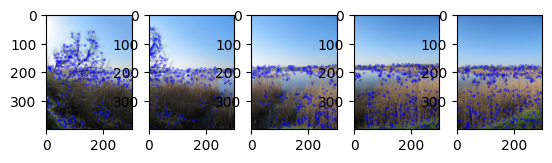

In [51]:
f, axarr = plt.subplots(1,5)
for i, image in enumerate(image_list):
    output_image = cv2.drawKeypoints(image, kp_orig_list[i], 0, (0, 0, 255),flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    axarr[i].imshow(output_image)
plt.show()

### Сопоставим ближайшие по дескрипторам ключевые точки

In [52]:
print(keypoints_list[0].shape)
(matches, H, status) = match_keypoints(keypoints_list[0], keypoints_list[1], descriptors_list[0], descriptors_list[1])

(558, 2)


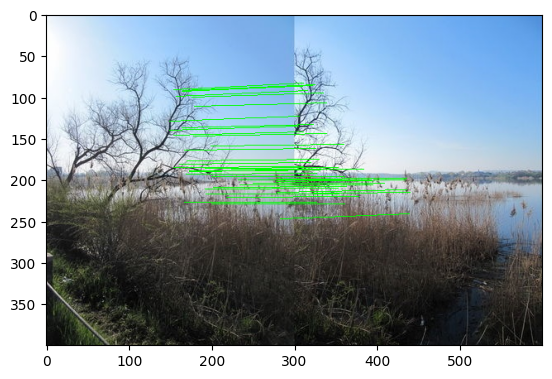

In [53]:
plt.imshow(draw_matches(image_list[0], image_list[1], keypoints_list[0], keypoints_list[1], matches, status))
plt.show()

### Посчитаем панораму для двух изображений, используя ключевые точки из SIFT

In [54]:
pano = warp_two_images(image_list[0], image_list[1])

(551, 2) (551, 128)


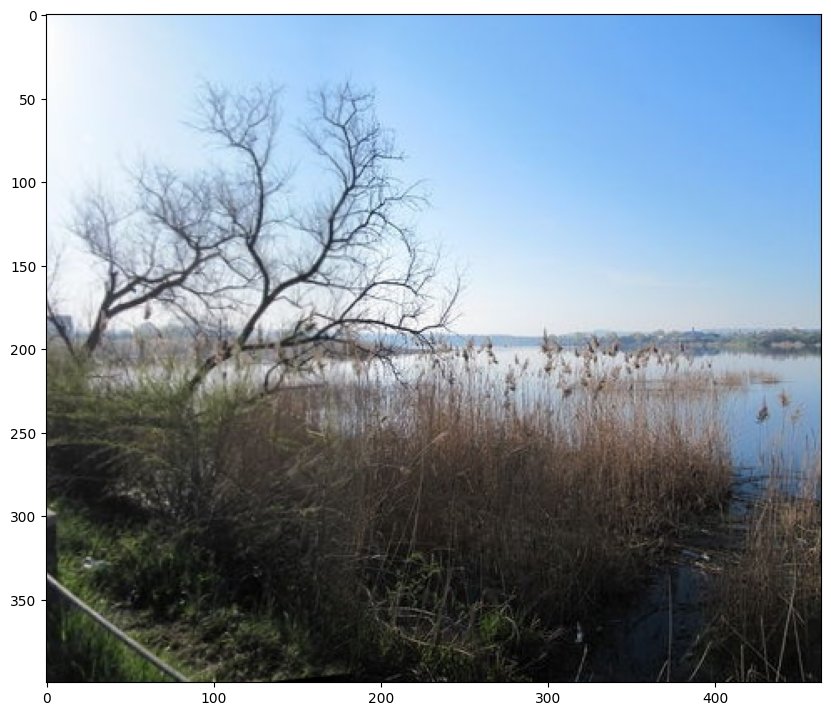

In [55]:
plt.figure(figsize=(10,10))
pano_normal = np.array(pano, dtype=float)/float(255)
plt.imshow(pano_normal)
plt.show()

### Напишем функцию для составления панорамы из множества изображений

In [44]:
def multi_stitching(list_images):
    """
    Можем просто добавлять к панораме новые фотографии слева направо. Т.е. warp_two_images(pano, image_i).
    Можем поступить хитрее, и начинать матчить с середины.
    """
    return full_panorama

### Построим панораму, используя ключевые точки из SIFT

3
3
(324, 2) (324, 128)
2
(551, 2) (551, 128)
(454, 2) (454, 128)
(529, 2) (529, 128)
(2373, 2) (2373, 128)


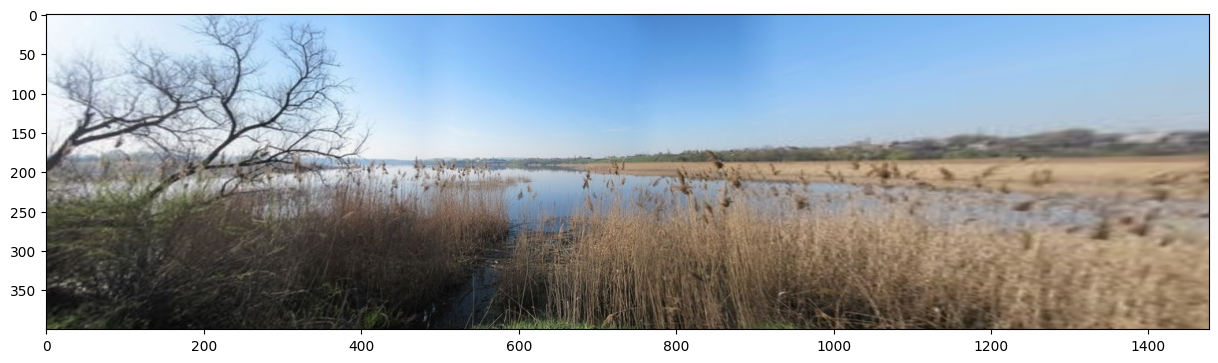

In [58]:
full_panorama = multi_stitching(image_list.copy())
full_panorama_normal = np.array(full_panorama, dtype=float)/float(255)
plt.figure(figsize=(15,10))
plt.imshow(full_panorama_normal)
plt.show()

## Панорама с ключевыми точками из Silk (10 балов)